In [18]:
import numpy as np
import open3d as o3d  # type: ignore
import matplotlib.pyplot as plt

from superprimitive_fusion.utils import bake_uv_to_vertex_colours, polar2cartesian

In [2]:
mesh = o3d.io.read_triangle_mesh("../data/power-drill/textured.obj", enable_post_processing=True)

bake_uv_to_vertex_colours(mesh)

mesh.compute_vertex_normals()

bb = mesh.get_minimal_oriented_bounding_box()
scale = np.mean(bb.get_max_bound())

In [3]:
###########################################################
# Geometry helpers                                        #
###########################################################

def _quad_to_tris(idx: tuple[int, int, int, int],
                  verts: np.ndarray) -> tuple[list[int], list[int]]:
    """Split a quadrilateral into two triangles.

    The shortest diagonal is used for convex quads, while concave quads are
    triangulated so both resulting triangles are oriented counter‑clockwise
    (positive signed area).
    """
    def signed_area(a, b, c):
        return (b[0] - a[0]) * (c[1] - a[1]) - (b[1] - a[1]) * (c[0] - a[0])

    # Convexity check – all cross products have the same sign
    crosses: list[float] = []
    for i in range(4):
        a, b, c = verts[i], verts[(i + 1) % 4], verts[(i + 2) % 4]
        ab, bc = b - a, c - b
        crosses.append(ab[0] * bc[1] - ab[1] * bc[0])
    is_convex = all(cp > 0 for cp in crosses)

    if is_convex:
        # pick the shorter diagonal
        d0 = np.sum((verts[0] - verts[2]) ** 2)
        d1 = np.sum((verts[1] - verts[3]) ** 2)
        if d0 <= d1:
            return [idx[0], idx[1], idx[2]], [idx[0], idx[2], idx[3]]
        return [idx[0], idx[1], idx[3]], [idx[1], idx[2], idx[3]]

    # Concave: test both diagonals for valid (positive‑area) triangles
    sa = [signed_area(*verts[[0, 1, 2]]), signed_area(*verts[[0, 2, 3]]),
          signed_area(*verts[[0, 1, 3]]), signed_area(*verts[[1, 2, 3]])]
    split1_ok = sa[0] > 0 and sa[1] > 0  # (0,1,2) & (0,2,3)
    split2_ok = sa[2] > 0 and sa[3] > 0  # (0,1,3) & (1,2,3)
    if split1_ok or not split2_ok:
        return [idx[0], idx[1], idx[2]], [idx[0], idx[2], idx[3]]
    return [idx[0], idx[1], idx[3]], [idx[1], idx[2], idx[3]]

###########################################################
# Colour helpers                                          #
###########################################################

def _interpolate_vertex_colors(mesh: o3d.geometry.TriangleMesh,
                               primitive_ids: np.ndarray,
                               bary_uv: np.ndarray) -> np.ndarray:
    """Interpolate per‑vertex colours of *mesh* at the hit points."""
    vcols = np.asarray(mesh.vertex_colors)
    tris = np.asarray(mesh.triangles, dtype=np.int32)

    tri = tris[primitive_ids]
    c0, c1, c2 = vcols[tri[:, :, 0]], vcols[tri[:, :, 1]], vcols[tri[:, :, 2]]

    u, v = bary_uv[:, :, 0], bary_uv[:, :, 1]
    w = 1.0 - u - v
    vcols = w[:, :, None] * c0 + u[:, :, None] * c1 + v[:, :, None] * c2

    return vcols

In [89]:
###########################################################
# Main entry point                                        #
###########################################################

mesh: o3d.geometry.TriangleMesh
cam_centre=polar2cartesian(r=0.3, lat=90, long=150)
look_dir=(0.0, 0.0, 0.0)
dropout_rate: float = 0
depth_error_std: float = 0.0
translation_error_std: float = 0.0
rotation_error_std_degs: float = 0.0
width_px: int = 360
height_px: int = 240
fov: float = 70.0
dist_thresh: float = 10.0

In [90]:
###############
# Ray casting #
###############
scene = o3d.t.geometry.RaycastingScene()
scene.add_triangles(o3d.t.geometry.TriangleMesh.from_legacy(mesh))

rays = o3d.t.geometry.RaycastingScene.create_rays_pinhole(
    fov_deg=fov,
    center=list(look_dir),
    eye=list(cam_centre),
    up=[0, 0, 1],
    width_px=width_px,
    height_px=height_px,
)

ans = scene.cast_rays(rays)
t_hit = ans["t_hit"].numpy()

# Intersection metadata (triangle id + barycentric uv)
prim_ids = ans["primitive_ids"].numpy().astype(np.int32)
bary_uv = ans.get("primitive_uvs", None).numpy()

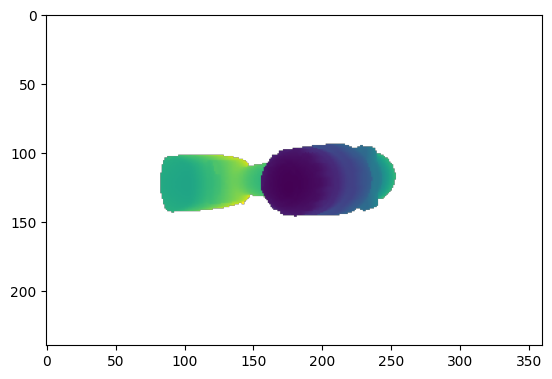

In [91]:
plt.imshow(t_hit)

In [97]:
######################
# Dropout / validity #
######################
valid = np.isfinite(t_hit).reshape(-1)
# random dropout mask
n_dropout = int(dropout_rate * valid.size)
if n_dropout:
    dropout_idx = np.random.choice(valid.size, n_dropout, replace=False)
    valid[dropout_idx] = False

In [98]:
########################
# Generate 3‑D vertices#
########################
rays_np = rays.numpy()  # (H*W,6)
origins = rays_np[..., :3]
dirs = rays_np[..., 3:]
noise = (depth_error_std * np.random.randn(*t_hit.shape)).astype(np.float32)
t_noisy = t_hit + noise
verts = origins + dirs * t_noisy[..., None]
verts = verts.reshape(-1, 3)

In [120]:
H, W = height_px, width_px

z = t_noisy.reshape(H, W)
valid_img = valid.reshape(H, W)

disp = np.zeros_like(z, dtype=np.float32)
disp[valid_img] = 1.0 / z[valid_img]

# Neighbor disparity diffs
dx = np.abs(disp[:, 1:] - disp[:, :-1])
dy = np.abs(disp[1:, :] - disp[:-1, :])

mask_x = valid_img[:, 1:] & valid_img[:, :-1]
mask_y = valid_img[1:, :] & valid_img[:-1, :]

vals = np.concatenate([dx[mask_x].ravel(), dy[mask_y].ravel()])
if vals.size:
    med = np.median(vals)
    mad = 1.4826 * np.median(np.abs(vals - med))
    thr = med + 10.0 * mad if mad > 0 else med * 1.5  # fallback if everything is flat
else:
    thr = np.inf  # nothing valid → nothing is bad by disparity

bad_x = (~mask_x) | (dx > thr)   # shape (H, W-1)
bad_y = (~mask_y) | (dy > thr)   # shape (H-1, W)

dd0 = np.abs(disp[:-1, :-1] - disp[1:, 1:])  # tl-br
dd1 = np.abs(disp[:-1, 1:]  - disp[1:, :-1]) # tr-bl
mask_d0 = valid_img[:-1, :-1] & valid_img[1:, 1:]
mask_d1 = valid_img[:-1, 1:]  & valid_img[1:, :-1]
bad_d0 = (~mask_d0) | (dd0 > thr)
bad_d1 = (~mask_d1) | (dd1 > thr)

In [121]:
######################################
# Optional colour interpolation step #
######################################
vcols: np.ndarray | None = None
if mesh.has_vertex_colors():
    if bary_uv is not None:
        vcols = _interpolate_vertex_colors(mesh, prim_ids, bary_uv)
    else:  # fall back to the first vertex of the hit triangle
        source_cols = np.asarray(mesh.vertex_colors)
        tri_first = np.asarray(mesh.triangles, dtype=np.int32)[prim_ids, 0]
        vcols = source_cols[tri_first]
    # invalid hits – set to black
    assert vcols is not None  # narrow type for mypy
    vcols.reshape(-1,3)[~valid] = np.full(3, 0.0)

In [122]:
########################
# Re‑construct surface #
########################
tris: list[list] = []
for v in range(H - 1):
    for u in range(W - 1):
        tl = v * W + u
        tr = tl + 1
        bl = tl + W
        br = bl + 1
        quad = (bl, tl, tr, br)
        if not (valid[quad[0]] and valid[quad[1]] and valid[quad[2]] and valid[quad[3]]):
            continue

        if (bad_x[v, u] or          # tl - tr
            bad_x[v + 1, u] or      # bl - br
            bad_y[v, u] or          # tl - bl
            bad_y[v, u + 1]):       # tr - br
            continue

        quad_verts = verts[list(quad)]

        t0, t1 = _quad_to_tris(quad, quad_verts)


        # Determine which diagonal was used and veto if that diag is bad
        uses02 = ((quad[0] in t0 and quad[2] in t0) or (quad[0] in t1 and quad[2] in t1))  # tl (idx1)?? careful: quad=(bl,tl,tr,br)
        uses13 = ((quad[1] in t0 and quad[3] in t0) or (quad[1] in t1 and quad[3] in t1))

        # Map our quad tuple to the tl,tr,bl,br notation we used for masks:
        # quad = (bl, tl, tr, br)
        bl_i, tl_i, tr_i, br_i = quad

        # Our bad_d0/1 indices are keyed by (v,u) for the quad itself.
        # tl-br diagonal is verts[1]-verts[3] in this quad tuple (tl_i, br_i)
        # tr-bl diagonal is verts[2]-verts[0] (tr_i, bl_i)

        if uses02:  # quad[0]-quad[2] = bl - tr  (that's tr-bl diag)
            if bad_d1[v, u]:  # tr-bl
                continue
        if uses13:  # quad[1]-quad[3] = tl - br  (that's tl-br diag)
            if bad_d0[v, u]:  # tl-br
                continue
        

        tris.extend([t0, t1])

mesh_out = o3d.geometry.TriangleMesh()
mesh_out.vertices = o3d.utility.Vector3dVector(verts)
mesh_out.triangles = o3d.utility.Vector3iVector(np.asarray(tris, dtype=np.int32)[:, [0,2,1]])

if vcols is not None:
    mesh_out.vertex_colors = o3d.utility.Vector3dVector(vcols.reshape(-1,3))

In [123]:
#############################
# Clean‑up / post‑processing#
#############################
mesh_out.remove_unreferenced_vertices()
mesh_out.remove_degenerate_triangles()
mesh_out.remove_duplicated_triangles()
mesh_out.remove_non_manifold_edges()
mesh_out.compute_vertex_normals()

TriangleMesh with 6806 points and 12838 triangles.

In [124]:
######################
# Registration error #
######################
mesh_out.translate(tuple(np.random.randn(3) * translation_error_std))
R = mesh.get_rotation_matrix_from_xyz(
    tuple(np.random.randn(3) * np.deg2rad(rotation_error_std_degs))
)
mesh_out.rotate(R, center=mesh_out.get_center())

TriangleMesh with 6806 points and 12838 triangles.

In [125]:
#######################
# Noised point cloud  #
#######################
pcd = o3d.t.geometry.PointCloud(o3d.core.Tensor(verts, dtype=o3d.core.Dtype.Float32))
pcd = pcd.translate(tuple(np.random.randn(3) * translation_error_std))
R = mesh.get_rotation_matrix_from_xyz(
    tuple(np.random.randn(3) * np.deg2rad(rotation_error_std_degs))
)
pcd = pcd.rotate(R, center=pcd.get_center())

In [126]:
o3d.visualization.draw_geometries([mesh_out])